#Install

SDK: https://platform.openai.com/docs/quickstart

Install the OpenAI Python library

In [3]:
!pip install --upgrade openai

from openai import OpenAI
import os
import json
import pandas as pd
import time
import re
import csv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00



# This is formatted as code


### Import packages

In [ ]:
import pathlib
import textwrap


from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

  # Used to securely store your API key
from google.colab import userdata

### Setup your API key

Before you can use the GPT API, you must first obtain an API key. If you don't already have one, create a key.

<a class="button button-primary" href="https://platform.openai.com/" target="_blank" rel="noopener noreferrer">Get an API key</a>


In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `OPENAI_API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `OPENAI_API_KEY` environment variable (the SDK will automatically pick it up from there).


In [ ]:
import os


client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key=userdata.get("OPENAI_API_KEY"),
)

### Data:
Our data will be taken from 162 snort rules that have already been manually labeled to techniques from MITRE ATT&CK.

In [7]:
!git clone https://github.com/trickdeath0/Labeling_IDS_to_MITRE.git

Cloning into 'Labeling_IDS_to_MITRE'...
remote: Enumerating objects: 441, done.
remote: Counting objects: 100% (441/441), done.
remote: Compressing objects: 100% (302/302), done.
remote: Total 441 (delta 232), reused 331 (delta 123), pack-reused 0
Receiving objects: 100% (441/441), 11.05 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (232/232), done.


In [ ]:
# data = pd.read_csv('/content/Labeling_IDS_to_MITRE/ground_truth.csv') # Nir experiment
data = pd.read_csv('/content/Labeling_IDS_to_MITRE/Semester_B/01 stratification/test_data_fix.csv') # Our experiment
print(data.head())
rules_list = data['Rule']
true_labels = data['technique ids']

#print(data['Sid'][0+41])
print(f"\n{len(data)=}")

     Sid                                  URL       technique ids  \
0  50094  https://snort.org/rule_docs/1-50094           ['T1187']   
1  38563  https://snort.org/rule_docs/1-38563           ['T1056']   
2    976    https://snort.org/rule_docs/1-976           ['T1204']   
3   1129   https://snort.org/rule_docs/1-1129           ['T1218']   
4  27967  https://snort.org/rule_docs/1-27967  ['T1505', 'T1219']   

                                                Rule  
0  alert tcp any $HTTP_PORTS -> any any ( msg:"IN...  
1  alert tcp $EXTERNAL_NET $HTTP_PORTS -> $HOME_N...  
2  alert tcp $EXTERNAL_NET any -> $HTTP_SERVERS $...  
3  alert tcp $EXTERNAL_NET any -> $HTTP_SERVERS $...  
4  alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP...  

len(data)=300


In [ ]:
def clean_response(text):
    text = text.data.replace(">", "").strip()  # Remove leading ">", whitespace
    try:
      text = text.replace("```json", "")
      text = text.replace("```", "")
    except:
      pass
    return text


# **Zero Shot (ZS):**
At this stage, the LLMs will receive a prompt that does not include the list of techniques from MITRE ATT&CK in order to examine the results of the models based on prior knowledge that has been trained. According to our request, the LLMs will classify the techniques according to the content of the rule.

In [ ]:
def ZS(snort_rule):

  prompt = f"""Rule: {snort_rule}
  Return a MITRE technique ID (with quotation marks) that related to the rule"""


  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "user", "content": f"{prompt}"}
    ]
   )


  return completion.choices[0].message

# **Prompting without techniques guide and without example (WTGWE):**
At this stage, the LLMs will receive a prompt that does not include the list of techniques from MITRE ATT&CK in order to examine the results of the models based on prior knowledge that has been trained. According to our request, the LLMs will classify the techniques according to the content of the rule.


**Prompt1**:

      prompt = f"""You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
      Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
      Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
      Please don't write anything but the JSON. Rule: {snort_rule}"""


**prompt2**:

      prompt2 = f"""I'm going to give you a Snort rule. Read the Snort rule carefully, because I'm going to given you a task about it. Here is the Snort rule: <snort_rule>{snort_rule}</snort_rule>

      First, find the techniques from MITRE ATT&CK that are most relevant to the Snort rule.

      Then, answer the task, for each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.

      Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.

      Thus, the format of your overall response should look like what's shown between the <examples></examples> tags. Make sure to follow the formatting and spacing exactly.


      <examples>
        [
          "sid": "2274",
          "Technique ID": "T1110",
          "Technique name": "Brute Force",
          "Quotes": [
            "\"PROTOCOL-POP login brute force attempt\"",
            "track by_dst,count 30,seconds 30"
          ],
          "Explanation": "The rule is looking for excessive \"USER\" commands within a short period of time, which are common indicators of brute-force attacks targeting the POP3 service."
        ]
        </examples>

        Do not include anything besides write the JSON.
        """


**prompt3**:

        prompt3 = f"""You work in a company that deals with information security, your role in the company is to label techniques from MITRE ATT&CK to the rules of IDS systems. The labeling between a rule and a technique indicates that the attacker operated with a technique that you found to be suitable for the rule that alerted the IDS system. Now we will test your knowledge labeling IDS rules for MITRE ATT&CK techniques. For your task, you're going to have a single Snort IDS rule and you'll need to label the most relevant techniques from MITRE ATT&CK associated with the rule. From the rule you receive, your labeling should be based on your knowledge and the information found within the 'msg' in the rule received. For each technique you call the rule, include the following information as JSON format in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.  Note: The value of the 'Quotes' field should contain quotation marks from the data sets relevant to the mapped technique. The value of the 'Explanation' should be your explanation of why you decided to give the technique and how it relates to the rule. The 'Technique ID' should be the official MITRE technique ID.
        Please don't write anything but the JSON. Rule: {snort_rule}""")


**prompt4**

        prompt4 = f'''You are going to receive a Snort rule and your task is to find as many MITRE ATT&CK techniques as possible that are associated with the rule. Note: You should categorize the techniques to 1 or 2. Technique of type 1 is a technique that you can associate with the rule directly based on the rule. Technique of type 2 is a technique that can be associated with the rule indirectly, based on your knowledge and understanding. The categorization value should be the value 1 or 2, based on the explanation given above. The quotes field value should contain quotes from the rules data that are relevant to the technique mapped and they are the main reason you believe the mapping to this technique is correct. The explanation’s value should be your explanation for why you decided to give the technique and how it is associated with the rule. The technique id should be the official MITRE technique id. For each technique include the following information as JSON: sid, Technique id, Technique name, Categorization, Quotes, Explanation. After each rule I will provide you with, answer according to the provided format. Please do not write anything else but the JSON. Rule: {snort_rule}''')


In [ ]:
def WTGWE(snort_rule):


  prompt = f"""Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
  Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
  Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
  Please don't write anything but the JSON. Rule: {snort_rule}"""


  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "system", "content": "You are an information security expert."},
      {"role": "user", "content": f"{prompt}"}
    ]
   )



  # prompt3 = f"""You work in a company that deals with information security, your role in the company is to label techniques from MITRE ATT&CK to the rules of IDS systems. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
  #   Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
  #   Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
  #   Please don't write anything but the JSON."""


  # completion = client.chat.completions.create(
  #   model="gpt-4-turbo",
  #   messages=[
  #     {"role": "system", "content": f"{prompt3}"},
  #     {"role": "user", "content": f" Rule: {snort_rule}"}
  #   ]
  # )

  return completion.choices[0].message

# **Prompting without techniques guide and with 1 example (WTG1E):**
At this stage, the LLMs will receive a prompt that does not include the list of techniques from MITRE ATT&CK in order to examine the results of the models based on prior knowledge that has been trained. According to our request, the LLMs will classify the techniques according to the content of the rule.

In addition, the prompt has one example (one shot)


In [ ]:
def WTG1E(snort_rule):

  # prompt_with_example = f"""Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
  #   Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
  #   Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
  #   Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET $HTTP_PORTS -> $HOME_NET any ( msg:""MALWARE-CNC Win.Trojan.GateKeylogger fake 404 response""; flow:to_client,established; http_stat_code; content:""200""; http_stat_msg; content:""OK""; pkt_data; content:"">404 Not Found<"",fast_pattern,nocase; content:"" requested URL / was not found ""; metadata:impact_flag red,ruleset community; service:http; T1056; classtype:trojan-activity; sid:38563; rev:4; )"
  #   """

  # answer_we_expect = f"""
  # [
  #     "sid": "38563",
  #     "Technique ID": "T1056",
  #     "Technique name": "Input Capture",
  #     "Quotes": "\"Input Capture techniques involve intercepting and capturing user input data, such as keystrokes, to obtain sensitive information. The rule indicates the presence of a Trojan (GateKeylogger) that mimics a '404 Not Found' error to disguise its communication with a command and control server, which is a common method used by keyloggers to stealthily capture input data.\"",
  #     "Explanation": "This event is generated when activity relating to malware is detected."
  # ]
  # """

  # prompt = f"""You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
  #   Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
  #   Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
  #   Please don't write anything but the JSON. Rule: {snort_rule}"""


  # completion = client.chat.completions.create(
  #   model="gpt-4-turbo",
  #   messages=[
  #     {"role": "system", "content": "You are an information security expert."},

  #     #Few Shot starts here:

  #     {"role": "user", "content": f"{prompt_with_example}"},
  #     {"role":"assistant","content":f"{answer_we_expect}"},

  #     #Finally send the data for which we want GPT to run the prompt and find solution

  #     {"role":"user","content":f"{prompt}"}

  #   ]
  #  )



  prompt_with_example = f"""Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET $HTTP_PORTS -> $HOME_NET any ( msg:""MALWARE-CNC Win.Trojan.GateKeylogger fake 404 response""; flow:to_client,established; http_stat_code; content:""200""; http_stat_msg; content:""OK""; pkt_data; content:"">404 Not Found<"",fast_pattern,nocase; content:"" requested URL / was not found ""; metadata:impact_flag red,ruleset community; service:http; T1056; classtype:trojan-activity; sid:38563; rev:4; )"
    """

  answer_we_expect = f"""
  [
      "sid": "38563",
      "Technique ID": "T1056",
      "Technique name": "Input Capture",
      "Quotes": "\"Input Capture techniques involve intercepting and capturing user input data, such as keystrokes, to obtain sensitive information. The rule indicates the presence of a Trojan (GateKeylogger) that mimics a '404 Not Found' error to disguise its communication with a command and control server, which is a common method used by keyloggers to stealthily capture input data.\"",
      "Explanation": "This event is generated when activity relating to malware is detected."
  ]
  """

  prompt = f"""You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: {snort_rule}"""


  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "system", "content": "You are an information security expert."},

      #Few Shot starts here:

      {"role": "system", "name":"example_user", "content": f"{prompt_with_example}"},
      {"role":"system", "name": "example_assistant", "content":f"{answer_we_expect}"},

      #Finally send the data for which we want GPT to run the prompt and find solution

      {"role":"user","content":f"{prompt}"}

    ]
   )



  # prompt = f"""Q: Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
  #   Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
  #   Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
  #   Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET $HTTP_PORTS -> $HOME_NET any ( msg:""MALWARE-CNC Win.Trojan.GateKeylogger fake 404 response""; flow:to_client,established; http_stat_code; content:""200""; http_stat_msg; content:""OK""; pkt_data; content:"">404 Not Found<"",fast_pattern,nocase; content:"" requested URL / was not found ""; metadata:impact_flag red,ruleset community; service:http; T1056; classtype:trojan-activity; sid:38563; rev:4; )"
  #   A: [
  #       "sid": "38563",
  #       "Technique ID": "T1056",
  #       "Technique name": "Input Capture",
  #       "Quotes": "\"Input Capture techniques involve intercepting and capturing user input data, such as keystrokes, to obtain sensitive information. The rule indicates the presence of a Trojan (GateKeylogger) that mimics a '404 Not Found' error to disguise its communication with a command and control server, which is a common method used by keyloggers to stealthily capture input data.\"",
  #       "Explanation": "This event is generated when activity relating to malware is detected."
  #   ]

  #   Q: Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return the most relevant techniques from MITRE ATT&CK that are related to the rule.
  #   Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
  #   Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
  #   Please don't write anything but the JSON. Rule: {snort_rule}
  #   A: """


  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "system", "content": "You are an information security expert."},
      {"role": "user", "content": f"{prompt}"}
    ]
   )


  return completion.choices[0].message

# **Prompting without techniques guide and with 2 example (WTG2E):**
At this stage, the LLMs will receive a prompt that does not include the list of techniques from MITRE ATT&CK in order to examine the results of the models based on prior knowledge that has been trained. According to our request, the LLMs will classify the techniques according to the content of the rule.

In addition, the prompt has two example (two shot)


In [ ]:
def WTG2E(snort_rule):

  prompt = f"""Q: You are an information security expert. Your task is to label IDS rules for MITER ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return no more than 2 most relevant techniques from MITER ATT&CK that are related to the rule.
        Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
        Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITER technique ID.
        Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET $HTTP_PORTS -> $HOME_NET any ( msg:""MALWARE-CNC Win.Trojan.GateKeylogger fake 404 response""; flow:to_client,established; http_stat_code; content:""200""; http_stat_msg; content:""OK""; pkt_data; content:"">404 Not Found<"",fast_pattern,nocase; content:"" requested URL / was not found ""; metadata:impact_flag red,ruleset community; service:http; T1056; classtype:trojan-activity; sid:38563; rev:4; )"
    A: [
        "sid": "38563",
        "Technique ID": "T1056",
        "Technique name": "Input Capture",
        "Quotes": "\"Input Capture techniques involve intercepting and capturing user input data, such as keystrokes, to obtain sensitive information. The rule indicates the presence of a Trojan (GateKeylogger) that mimics a '404 Not Found' error to disguise its communication with a command and control server, which is a common method used by keyloggers to stealthily capture input data.\"",
        "Explanation": "This event is generated when activity relating to malware is detected."
    ]

    Q: You are an information security expert. Your task is to label IDS rules for MITER ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return no more than 2 most relevant techniques from MITER ATT&CK that are related to the rule.
        Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
        Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITER technique ID.
        Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:""SERVER-OTHER Apache Log4j logging remote code execution attempt""; flow:to_server,established; http_header; content:""upper"",fast_pattern,nocase; pcre:""/(%(25)?24|\x24)(%(25)?7b|\x7b)upper(%(25)?3a|\x3a)/i""; metadata:policy balanced-ips drop,policy connectivity-ips drop,policy max-detect-ips drop,policy security-ips drop,ruleset community; service:http; classtype:attempted-user; gid:1; sid:58738; rev:5; )"
    A: [
        "sid": "23934",
        "Technique ID": "T1190",
        "Technique name": "Exploit Public-Facing Application",
        "Quotes": "Adversaries may attempt to exploit a weakness in an Internet-facing host or system to initially access a network.",
        "Explanation": "This rule looks for attempts to exploit a remote code execution vulnerability in Log4j's "Lookup" functionality."
    ]

    Q: You are an information security expert. Your task is to label IDS rules for MITER ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return no more than 2 most relevant techniques from MITER ATT&CK that are related to the rule.
        Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
        Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITER technique ID.
        Please don't write anything but the JSON. Rule: {snort_rule}
    A: """


  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "system", "content": "You are an information security expert."},
      {"role": "user", "content": f"{prompt}"}
    ]
   )


  return completion.choices[0].message

# Pre collection data for TG

In [ ]:
def recursive_enter(path: str, file_list: list = None) -> list:
    if file_list is None:
        file_list = []

    try:
        os.chdir(path)  # Change path

        items = os.listdir()  # List everything in the directory
        for item in items:
            full_path = os.path.join(path, item)

            if full_path.endswith(".json"):
                with open(full_path) as f:
                    file_list.append(json.load(f))

    except Exception as e:
        print(f"An error occurred: {e}")

    return file_list

tacticFolder = "/content/Labeling_IDS_to_MITRE/Semester_A/Extract data from MITRE ATTACK/techniques_split"
file_list = []
MITRE_Technique = recursive_enter(tacticFolder, file_list)
print(len(MITRE_Technique))
os.chdir("/content/")

All_MITRE_Technique_json = None
All_MITRE_Technique_json_path = "/content/Labeling_IDS_to_MITRE/Semester_A/Extract data from MITRE ATTACK/combined_techniques_split.json"
# Open and read the JSON file
with open(All_MITRE_Technique_json_path, 'r') as file:
    All_MITRE_Technique_json = json.load(file)

11


# **Prompting with techniques guide and without example (TGWE):**
In the next step, we will provide the LLMs with the list of all the techniques from MITRE ATT&CK, to guarantee that the models are targeted to the present techniques, even the infrequently used ones. Each technique will include the technique number, the name of the technique and its description. The techniques will be provided to the models in the form of batches (due to the memory limit of the models) and after each batch we will ask him to classify the appropriate techniques from the list he received (if exist), finally we will unite the model's answers for each individual rule.


In [ ]:
def TGWE(snort_rule, techniques, limit):
  if limit:
    str_limit = "maximum 2"
  else:
    str_limit = "the"

  prePrompt = f"""You are an information security expert. Now I will provide you information about techniques from MITRE ATT&CK, you will use the information for a task you will receive later. Do not reply to the information you receive."""

  dataPrompt = f"The information:\n {str(techniques)}"

  response_data = f"""You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return {str_limit} most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: {snort_rule}"""

  tg_data_list = prePrompt + dataPrompt + response_data


  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "system", "content": "You are an information security expert."},
      {"role": "user", "content": f"{tg_data_list}"}
    ]
   )


  return completion.choices[0].message



# **Prompting with techniques guide and with 1 example (TG1E):**
In the next step, we will provide the LLMs with the list of all the techniques from MITRE ATT&CK, to guarantee that the models are targeted to the present techniques, even the infrequently used ones. Each technique will include the technique number, the name of the technique and its description. The techniques will be provided to the models in the form of batches (due to the memory limit of the models) and after each batch we will ask him to classify the appropriate techniques from the list he received (if exist), finally we will unite the model's answers for each individual rule.

In addition, the prompt has one example (one shot)

In [ ]:
def TG1E(snort_rule, techniques, limit):
  if limit:
    str_limit = "maximum 2"
  else:
    str_limit = "the"

  prePrompt = f"""You are an information security expert. Now I will provide you information about techniques from MITRE ATT&CK, you will use the information for a task you will receive later. Do not reply to the information you receive."""

  dataPrompt = f"The information:\n {str(techniques)}"

  response_data = f"""Q: You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return {str_limit} most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET $HTTP_PORTS -> $HOME_NET any ( msg:""MALWARE-CNC Win.Trojan.GateKeylogger fake 404 response""; flow:to_client,established; http_stat_code; content:""200""; http_stat_msg; content:""OK""; pkt_data; content:"">404 Not Found<"",fast_pattern,nocase; content:"" requested URL / was not found ""; metadata:impact_flag red,ruleset community; service:http; T1056; classtype:trojan-activity; sid:38563; rev:4; )"
    A: [
        "sid": "38563",
        "Technique ID": "T1056",
        "Technique name": "Input Capture",
        "Quotes": "\"Input Capture techniques involve intercepting and capturing user input data, such as keystrokes, to obtain sensitive information. The rule indicates the presence of a Trojan (GateKeylogger) that mimics a '404 Not Found' error to disguise its communication with a command and control server, which is a common method used by keyloggers to stealthily capture input data.\"",
        "Explanation": "This event is generated when activity relating to malware is detected."
    ]

    Q: You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return {str_limit} most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: {snort_rule}
    A: """

  tg_data_list = prePrompt + dataPrompt + response_data

  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "system", "content": "You are an information security expert."},
      {"role": "user", "content": f"{tg_data_list}"}
    ]
   )


  return completion.choices[0].message


# **Prompting with techniques guide and with 2 example (TG2E):**
In the next step, we will provide the LLMs with the list of all the techniques from MITRE ATT&CK, to guarantee that the models are targeted to the present techniques, even the infrequently used ones. Each technique will include the technique number, the name of the technique and its description. The techniques will be provided to the models in the form of batches (due to the memory limit of the models) and after each batch we will ask him to classify the appropriate techniques from the list he received (if exist), finally we will unite the model's answers for each individual rule.

In addition, the prompt has two example (two shot)

In [ ]:
def TG2E(snort_rule, techniques, limit):
  if limit:
    str_limit = "maximum 2"
  else:
    str_limit = "the"

  prePrompt = f"""You are an information security expert. Now I will provide you information about techniques from MITRE ATT&CK, you will use the information for a task you will receive later. Do not reply to the information you receive."""

  dataPrompt = f"The information:\n {str(techniques)}"

  response_data = f"""Q: You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return {str_limit} most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET $HTTP_PORTS -> $HOME_NET any ( msg:""MALWARE-CNC Win.Trojan.GateKeylogger fake 404 response""; flow:to_client,established; http_stat_code; content:""200""; http_stat_msg; content:""OK""; pkt_data; content:"">404 Not Found<"",fast_pattern,nocase; content:"" requested URL / was not found ""; metadata:impact_flag red,ruleset community; service:http; T1056; classtype:trojan-activity; sid:38563; rev:4; )"
    A: [
        "sid": "38563",
        "Technique ID": "T1056",
        "Technique name": "Input Capture",
        "Quotes": "\"Input Capture techniques involve intercepting and capturing user input data, such as keystrokes, to obtain sensitive information. The rule indicates the presence of a Trojan (GateKeylogger) that mimics a '404 Not Found' error to disguise its communication with a command and control server, which is a common method used by keyloggers to stealthily capture input data.\"",
        "Explanation": "This event is generated when activity relating to malware is detected."
    ]

    Q: You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return {str_limit} most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: "alert tcp $EXTERNAL_NET any -> $HOME_NET $HTTP_PORTS ( msg:""SERVER-OTHER Apache Log4j logging remote code execution attempt""; flow:to_server,established; http_header; content:""upper"",fast_pattern,nocase; pcre:""/(%(25)?24|\x24)(%(25)?7b|\x7b)upper(%(25)?3a|\x3a)/i""; metadata:policy balanced-ips drop,policy connectivity-ips drop,policy max-detect-ips drop,policy security-ips drop,ruleset community; service:http; classtype:attempted-user; gid:1; sid:58738; rev:5; )"
    A: [
        "sid": "23934",
        "Technique ID": "T1190",
        "Technique name": "Exploit Public-Facing Application",
        "Quotes": "Adversaries may attempt to exploit a weakness in an Internet-facing host or system to initially access a network.",
        "Explanation": "This rule looks for attempts to exploit a remote code execution vulnerability in Log4j's "Lookup" functionality."
    ]

    Q: You are an information security expert. Your task is to label IDS rules for MITRE ATT&CK techniques based on your cybersecurity knowledge. For the task, you are going to get a single Snort IDS rule and you will need to return {str_limit} most relevant techniques from MITRE ATT&CK that are related to the rule.
    Try to search based on keywords and based on the knowledge you have. For each technique include the following information as JSON in this order: 'Sid', 'Technique ID', 'Technique Name', 'Quotes', 'Explanation'.
    Note: The value of the citation field should contain quotation marks from the data sets relevant to the mapped technique are the main reason you chose this technique to be correct. The value of the explanation should be your explanation of why you decided to give the technique and how it relates to the rule. The technique ID should be the official MITRE technique ID.
    Please don't write anything but the JSON. Rule: {snort_rule}
    A: """


  tg_data_list = prePrompt + dataPrompt + response_data

  completion = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
      {"role": "system", "content": "You are an information security expert."},
      {"role": "user", "content": f"{tg_data_list}"}
    ]
   )


  return completion.choices[0].message


# Write to csv

Write Zero Shot

In [ ]:
def write_csv_ZS(filename, rule_dict):
  # Define the field names
  field_names = ["Technique_id", "True_labels"]

  # Open the CSV file in write mode (truncating any existing content)
  with open(filename, "w", newline="") as csvfile: # "prompting_without_techniques_guide.csv"
      # Create a DictWriter object with the specified field names
      writer = csv.DictWriter(csvfile, fieldnames=field_names)

      # Write the header row
      writer.writeheader()

      # Extract relevant data from each item and write it as a dictionary
      counter = 0
      for key, value in rule_dict.items():
        text = clean_response(value)
        technique_ids = []

        if "'Sid" in text:
          # Define a regex pattern to switch single quotes to double quotes
          pattern = re.compile(r"((^|\s)'((?:[^'\\]|\\.)*)'(?=[\s.,:;!?)]))|(:\s*'((?:[^'\\]|\\.)+)')")
          # Switch single quotes to double quotes
          text = pattern.sub(lambda x: x.group().replace("'", '"'), text)

          pattern = re.compile(r'"\S+"[\s\.]|\s"[\w\s]*"\s')
          text = re.sub(pattern, "", text)

        # Extracting "TXXXX" numbers using regular expression
        technique_ids = re.findall(r'[\'\"](T\d+(?:\.\d+)?)', text)

        # Extracting "Sid"
        match = re.search(r'[\'\"][s|S]id[\'\"]: [\'\"](\d+)[\'\"]', text)
        if match:
            sid_number = match.group(1)


        # Assuming each item has all necessary fields:
        insertRow = {
            "Technique_id": technique_ids,  # Handle potential absence
            "True_labels": true_labels[counter],
        }
        writer.writerow(insertRow)
        counter += 1


Write without techniques guide

In [ ]:
def write_csv_WTG(filename, rule_dict):
  # Define the field names
  field_names = ["Sid", "Response", "Technique_id", "True_labels"]

  # Open the CSV file in write mode (truncating any existing content)
  with open(filename, "w", newline="") as csvfile: # "prompting_without_techniques_guide.csv"
      # Create a DictWriter object with the specified field names
      writer = csv.DictWriter(csvfile, fieldnames=field_names)

      # Write the header row
      writer.writeheader()

      # Extract relevant data from each item and write it as a dictionary
      counter = 0
      for key, value in rule_dict.items():
        text = clean_response(value)
        technique_ids = []

        if "'Sid" in text:
          # Define a regex pattern to switch single quotes to double quotes
          pattern = re.compile(r"((^|\s)'((?:[^'\\]|\\.)*)'(?=[\s.,:;!?)]))|(:\s*'((?:[^'\\]|\\.)+)')")
          # Switch single quotes to double quotes
          text = pattern.sub(lambda x: x.group().replace("'", '"'), text)

          pattern = re.compile(r'"\S+"[\s\.]|\s"[\w\s]*"\s')
          text = re.sub(pattern, "", text)

        # Extracting "TXXXX" numbers using regular expression
        technique_ids = re.findall(r'[\'\"](T\d+(?:\.\d+)?)', text)

        # Extracting "Sid"
        match = re.search(r'[\'\"][s|S]id[\'\"]: [\'\"](\d+)[\'\"]', text)
        if match:
            sid_number = match.group(1)


        # Assuming each item has all necessary fields:
        insertRow = {
            "Sid": sid_number,
            "Response": text,
            "Technique_id": technique_ids,  # Handle potential absence
            "True_labels": true_labels[counter],
        }
        writer.writerow(insertRow)
        counter += 1


Write with techniques guide

In [ ]:
import csv
import re

headersCSV_TG = ["Sid", "Response_11_Iteration", "Without_Prompt_Limit_Without_Competition_Without_Limit_Return",
                 "Without_Prompt_Limit_Without_Competition_With_Limit_Return",
                 "Response_Competition_1", "Response_Competition_2", "Response_Competition_3",
                 "Without_Prompt_Limit_With_Competition_Without_Limit_Return",
                 "Without_Prompt_Limit_With_Competition_With_Limit_Return", "True_labels"]

def init_file(fileName):
  # Initial write to csv with header
  with open(fileName, 'w', newline='') as csvfile: # 'prompting_with_techniques_guide.csv'
      writer = csv.DictWriter(csvfile, fieldnames=headersCSV_TG)
      writer.writeheader()

def appendToCSV(rows_data, counter, fileName, technique_ids) -> None:
    '''
    rows_data -> {213: [<IPython.core.display.Markdown object>, <IPython.core.display.Markdown object>, ...]}
    '''
    all_technique, top_2_all_technique, all_competition, top_2_all_competition, tg_dict_Batch1, tg_dict_Batch2, tg_dict_Batch3 = technique_ids

    # Open the CSV file in append mode to add new rows
    with open(fileName, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headersCSV_TG)

        # Loop through each row and write data
        for row, value in rows_data.items():
            response_text = ""
            for i in value:
                text = clean_response(i)
                response_text += text
                #print(text)

            insertRow = {
                "Sid": row,
                "Response_11_Iteration": response_text,
                "Without_Prompt_Limit_Without_Competition_Without_Limit_Return": all_technique,
                "Without_Prompt_Limit_Without_Competition_With_Limit_Return": top_2_all_technique,
                "Response_Competition_1": tg_dict_Batch1,
                "Response_Competition_2": tg_dict_Batch2,
                "Response_Competition_3": tg_dict_Batch3,
                "Without_Prompt_Limit_With_Competition_Without_Limit_Return": all_competition,
                "Without_Prompt_Limit_With_Competition_With_Limit_Return": top_2_all_competition,
                "True_labels": true_labels[counter]
            }

            # Write the row to the CSV file
            writer.writerow(insertRow)


# WTG - Generic

In [ ]:
def WTG(functionName, rules_list):
  rule_dict = {}
  max_retries = 3  # Maximum number of retries

  for index, rule in enumerate(rules_list):
      retries = 0
      print(f"-----------------{index}--------------------")
      #print(rule)
      while retries < max_retries:
          try:
              res = functionName(rule)
              print(res)
              text = str(res.content)
              # Check if the text contains the desired pattern
              t_numbers = re.findall(r'[\'\"](T\d+(?:\.\d+)?)', text)
              if t_numbers:  # If the pattern is found
                  rule_dict[data['Sid'][index]] = to_markdown(text)
                  break  # Break out of the retry loop if successful
              else:
                  print("Desired pattern not found in the text. Retrying...")
                  retries += 1
                  time.sleep(1)  # Wait for a short duration before retrying

              time.sleep(2) # remove after we have money :)
          except Exception as e:
              print(f"An error occurred: {e}")
              retries += 1
              if retries < max_retries:
                  print(f"Retrying... ({retries}/{max_retries})")
                  time.sleep(1)  # Wait for a short duration before retrying
              else:
                  print("Max retries reached. Unable to process this rule.")

  # If sending fails, attempt to send again
  try:
      # Code to send data
      pass
  except Exception as e:
      print(f"Sending failed: {e}")
      # Retry sending here

  return rule_dict


# TG - Generic

In [ ]:
def get_the_most_relevate_technique(tg_dict):
    technique_ids = []
    for row, value in tg_dict.items():
        response_text = ""
        for i in value:
            text = clean_response(i)
            response_text += text
            try:
                # Extracting "TXXXX" numbers using regular expression
                technique_ids.extend(re.findall(r'[\'\"](T\d+(?:\.\d+)?)', text))
            except Exception as e:
                print(f"Error extracting technique IDs: {e}")
    return technique_ids


def stratification():
  import ast

  technique_counts = (data['technique ids'].value_counts())
  # Converting the Series to a dictionary
  technique_counts_dict = technique_counts.to_dict()
  #print(technique_counts_dict)

  # Initialize the new dictionary
  new_data = {}
  # Iterate through the original dictionary
  for key, value in technique_counts_dict.items():
      # Convert the string key to a list
      techniques = ast.literal_eval(key)
      # Iterate through the techniques in the list
      for technique in techniques:
          # Add the technique to the new dictionary
          if technique in new_data:
              new_data[technique] += value
          else:
              new_data[technique] = value

  sorted_data = dict(sorted(new_data.items(), key=lambda item: item[1], reverse=True))
  # Print the new dictionary
  return sorted_data


def tg_split_data(functionName, rules_list_index, index, fileName, limit):

  for rule in rules_list_index:
    print(f"index {index} \t Sid: {data['Sid'][index]}")

    tg_dict = {}
    count = 0 #####
    response_tg_dict_11_iteration = ""
    for batch in MITRE_Technique: # 11 files
      res = functionName(rule, batch, limit)
      sid = data['Sid'][index]
      if sid not in tg_dict:
        tg_dict[sid] = []
      try:
        tg_dict[sid].append(to_markdown(str(res.content)))
      except:
        tg_dict[sid].append(to_markdown("{}"))
      print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~{count}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~") #####
      print(to_markdown(str(res.content)))
      count += 1 #######
      #time.sleep(15)
    response_tg_dict_11_iteration = tg_dict



    # Get up to 3 rules (STATIC)
    new_batch = []
    technique_ids_from_11_batchs = get_the_most_relevate_technique(tg_dict)
    for technique_id in technique_ids_from_11_batchs:
        if technique_id in All_MITRE_Technique_json[0]:
            new_batch.append((technique_id, All_MITRE_Technique_json[0][technique_id]))
    new_dict = dict(new_batch)
    print(new_dict)



    # get the most frequency from top_2_new_batch:
    res_stratification = stratification()
    # Filter keys from res_stratification that are present in new_batch
    filtered_keys = [key for key in new_dict.keys() if key in res_stratification.keys()]

    # Sort the filtered keys based on counts in res_stratification
    sorted_keys = sorted(filtered_keys, key=res_stratification.get, reverse=True)

    # Get the top two keys
    top_2_new_batch = sorted_keys[:2]



    # Run new_batch 3 times
    dictionary_of_rules = {}
    tg_dict = {}

    tg_dict_Batch1 = {}
    tg_dict_Batch2 = {}
    tg_dict_Batch3 = {}

    for epoch in range(3):
        #time.sleep(1)
        tg_dict = {}
        res = functionName(rule, new_dict, limit)
        sid = data['Sid'][index]
        if sid not in tg_dict:
            tg_dict[sid] = []
        try:
            tg_dict[sid].append(to_markdown(str(res.content)))
        except:
            tg_dict[sid].append(to_markdown("{}"))

        inner_technique_ids = get_the_most_relevate_technique(tg_dict)
        for technique in inner_technique_ids:
            if technique not in dictionary_of_rules:
                dictionary_of_rules[technique] = 1
            else:
                dictionary_of_rules[technique] += 1
        print(dictionary_of_rules)
        print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~BATCH {epoch + 1}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        if (epoch == 0):
          tg_dict_Batch1[sid] = str(res.content)
        elif (epoch == 1):
          tg_dict_Batch2[sid] = str(res.content)
        else:
          tg_dict_Batch3[sid] = str(res.content)


    if dictionary_of_rules: # This checks if the dictionary is empty
      # Step 1: Find the maximum value in dictionary_of_rules
      max_number_value = max(dictionary_of_rules.values())

      # Step 2: Collect all keys with the maximum value
      max_techniuqeId_keys = [key for key, value in dictionary_of_rules.items() if value == max_number_value]
      if len(max_techniuqeId_keys) == 1:
        sorted_values = sorted(dictionary_of_rules.values(), reverse=True)

        # Get the second highest value
        if len(sorted_values) >= 2:
            second_max_value = sorted_values[1]
            second_max_techniuqeId_keys = [key for key, value in dictionary_of_rules.items() if value == second_max_value]

            if len(second_max_techniuqeId_keys) >= 2:
              res_stratification = stratification()
              # Find the key with the highest count in the res_stratification dictionary
              max_count_key = max(res_stratification, key=res_stratification.get)
              max_techniuqeId_keys.extend(max_count_key)
            else:
              max_techniuqeId_keys.extend(second_max_techniuqeId_keys)

      elif len(max_techniuqeId_keys) > 2:
        res_stratification = stratification()

        keys_from_dict1 = set(dictionary_of_rules.keys())
        filtered_dict2 = {key: value for key, value in res_stratification.items() if key in keys_from_dict1}
        sorted_keys = sorted(filtered_dict2, key=filtered_dict2.get, reverse=True)
        max_techniuqeId_keys = sorted_keys[:2]

    else:
      max_techniuqeId_keys = []



    # Write to CSV
    """
    response_tg_dict_11_iteration => all content from 11 iteration

      **Without Competition**
        new_batch => All techniques iterating from 11 iterations on one SNORT rule.
        top_2_new_batch => From new_batch return the most 2 frequency.

      **With Competition**
        dictionary_of_rules.keys() => All techniques iterating from 3 batch.
        max_techniuqeId_keys => From Batch return the most 2 frequency.
    """

    technique_ids = (list(new_dict.keys()), top_2_new_batch, list(dictionary_of_rules.keys()), max_techniuqeId_keys, tg_dict_Batch1, tg_dict_Batch2, tg_dict_Batch3)
    appendToCSV(response_tg_dict_11_iteration, index, fileName, technique_ids)
    index += 1

# Run Experiments

without data

In [ ]:
# #  Without Example Without Techniuqes Guide
# rule_dict_ZS = WTG(ZS, rules_list)
# write_csv_ZS("zero_shot.csv", rule_dict_ZS)


#  # Without Example Without Techniuqes Guide
# rule_dict_WTG = WTG(WTGWE, rules_list)
# write_csv_WTG("prompting_without_techniques_guide_zero_shot_with_limit.csv", rule_dict_WTG)


#  # With 1 Example Without Techniuqes Guide
# rule_dict_WTG1E = WTG(WTG1E, rules_list)
# write_csv_WTG("prompting_without_techniques_guide_one_shot_with_limit.csv", rule_dict_WTG1E)


 # With 2 Example Without Techniuqes Guide
rule_dict_WTG2E = WTG(WTG2E, rules_list)
write_csv_WTG("prompting_without_techniques_guide_two_shot_with_limit.csv", rule_dict_WTG2E)

-----------------0--------------------
ChatCompletionMessage(content='[\n    {\n        "sid": "50094",\n        "Technique ID": "T1557",\n        "Technique name": "Man-in-the-Middle",\n        "Quotes": "This technique intercepts files in the network communication between two systems to capture or manipulate the data being transmitted.",\n        "Explanation": "The rule detects an HTTP attack attempt consistent with a Man-in-the-Middle scenario where a malicious server is sending altered HTTP responses to intercept and manipulate data."\n    }\n]', role='assistant', function_call=None, tool_calls=None)
-----------------1--------------------
ChatCompletionMessage(content='[\n    {\n        "sid": "38563",\n        "Technique ID": "T1056",\n        "Technique Name": "Input Capture",\n        "Quotes": "Input Capture techniques involve intercepting and capturing user input data, such as keystrokes, to obtain sensitive information. The rule indicates the presence of a Trojan (GateKeylog

with data

In [ ]:
fileName = 'prompting_with_techniques_guide_zero_shot_False.csv' #0
# fileName = 'prompting_with_techniques_guide_one_shot_False.csv' #1
# fileName = 'prompting_with_techniques_guide_two_shot_False.csv' #2

In [ ]:
# Run this only for the first time to create the file!!
init_file(fileName)

In [ ]:
 # Without Example With Techniuqes Guide
rule_dict_TGWE_01 = rules_list # index 0-99
tg_split_data(TGWE, rule_dict_TGWE_01, 0, fileName, False)

# rule_dict_TGWE_02 = rules_list[100:200] # index 100-199
# tg_split_data(TGWE, rule_dict_TGWE_02, 100, fileName)

# rule_dict_TGWE_03 = rules_list[200:] # index 200-299
# tg_split_data(TGWE, rule_dict_TGWE_03, 200, fileName)



# # With 1 Example With Techniuqes Guide
# rule_dict_TG1E_01 = rules_list[7:] # index 0-99
# tg_split_data(TG1E, rule_dict_TG1E_01, 7, fileName, False)

# rule_dict_TG1E_02 = rules_list[100:200] # index 100-199
# tg_split_data(TG1E, rule_dict_TG1E_02, 100, fileName)

# rule_dict_TG1E_03 = rules_list[200:] # index 200-299
# tg_split_data(TG1E, rule_dict_TG1E_03, 200, fileName)



#  # With 2 Example With Techniuqes Guide
# rule_dict_TG2E_01 = rules_list # index 0-99
# tg_split_data(TG2E, rule_dict_TG2E_01, 0, fileName, False)

# rule_dict_TG2E_02 = rules_list[100:200] # index 100-199
# tg_split_data(TG2E, rule_dict_TG2E_02, 100, fileName)

# rule_dict_TG2E_03 = rules_list[200:] # index 200-299
# tg_split_data(TG2E, rule_dict_TG2E_03, 200, fileName)

index 0 	 Sid: 286
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~0~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~1~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~2~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~3~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~4~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~5~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~6~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~7~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.core.display.Markdown object>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~8~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<IPython.cor

# Evaluation


*   Persicion
*   Recall
*   F-1



In [1]:
import ast
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import math

def evaluation(true_labels, predicted_labels, is_printable):
  results = []
  recall = []
  precision = []
  f1 = []


  for i in range(len(true_labels)):
    trueList = ast.literal_eval(true_labels[i])
    predList = ast.literal_eval(predicted_labels[i])
    # Extract only the 'TXXXX' part from each string in the list
    predList = [item.split('.')[0] if '.' in item else item for item in predList]
    intersection = set(trueList).intersection(set(predList))
    #print(list(intersection))
    if (len(predList) != 0):
      recall.append(len(intersection) / len(set(trueList)))
      precision.append(len(intersection) / len(set(predList)))
      try:
        f1.append((2 * precision[i] * recall[i]) / (recall[i] + precision[i]))
      except:
        f1.append(0)

    ####### the real
    else:
      recall.append(0)
      precision.append(0)
      f1.append(0)

  # Avg.
  average_recall = sum(recall) / len(recall)
  average_precision = sum(precision) / len(precision)
  average_f1 = (2 * average_recall * average_precision) / (average_recall + average_precision)

  if is_printable:
    print("Metric    |   Score")
    print("-------------------")
    print(f"Precision |   {average_precision:.2f}")
    print(f"Recall    |   {average_recall:.2f}")
    print(f"F1 Score  |   {average_f1:.2f}")
  else:
    results.append((average_precision, average_recall, average_f1))
    return results


#### ZS

In [ ]:
loadData = pd.read_csv("zero_shot.csv")
true_labels_ZS = loadData['True_labels']
predicted_labels = loadData['Technique_id']

evaluation(true_labels_ZS, predicted_labels)


Metric    |   Score
-------------------
Precision |   0.04
Recall    |   0.04
F1 Score  |   0.04


#### WTGWE

In [ ]:
loadData = pd.read_csv("prompting_without_techniques_guide_zero_shot.csv")
true_labels_WTGWE = loadData['True_labels']
predicted_labels = loadData['Technique_id']

evaluation(true_labels_WTGWE, predicted_labels, True)


Metric    |   Score
-------------------
Precision |   0.18
Recall    |   0.18
F1 Score  |   0.18


#### WTG1E

In [ ]:
loadData = pd.read_csv("prompting_without_techniques_guide_one_shot.csv")
true_labels_WTG1E = loadData['True_labels']
predicted_labels = loadData['Technique_id']

evaluation(true_labels_WTG1E, predicted_labels)


Metric    |   Score
-------------------
Precision |   0.55
Recall    |   0.53
F1 Score  |   0.54


#### WTG2E

In [ ]:
loadData = pd.read_csv("prompting_without_techniques_guide_two_shot_with_limit.csv")
true_labels_WTG2E = loadData['True_labels']
predicted_labels = loadData['Technique_id']

evaluation(true_labels_WTG2E, predicted_labels, True)


Metric    |   Score
-------------------
Precision |   0.19
Recall    |   0.21
F1 Score  |   0.20


#### TGWE

In [4]:
loadData = pd.read_csv('prompting_with_techniques_guide_zero_shot_False.csv')
true_labels_TGWE = loadData['True_labels']
predicted_labels = loadData['Without_Prompt_Limit_Without_Competition_Without_Limit_Return']

evaluation(true_labels_TGWE, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_Without_Competition_With_Limit_Return']
evaluation(true_labels_TGWE, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_With_Competition_Without_Limit_Return']
evaluation(true_labels_TGWE, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_With_Competition_With_Limit_Return']
evaluation(true_labels_TGWE, predicted_labels, True)

Metric    |   Score
-------------------
Precision |   0.06
Recall    |   0.48
F1 Score  |   0.10

Metric    |   Score
-------------------
Precision |   0.10
Recall    |   0.18
F1 Score  |   0.13

Metric    |   Score
-------------------
Precision |   0.23
Recall    |   0.30
F1 Score  |   0.26

Metric    |   Score
-------------------
Precision |   0.23
Recall    |   0.28
F1 Score  |   0.26


#### TG1E

In [5]:
loadData = pd.read_csv('prompting_with_techniques_guide_one_shot_False.csv')
true_labels_TG1E = loadData['True_labels']
predicted_labels = loadData['Without_Prompt_Limit_Without_Competition_Without_Limit_Return']

evaluation(true_labels_TG1E, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_Without_Competition_With_Limit_Return']
evaluation(true_labels_TG1E, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_With_Competition_Without_Limit_Return']
evaluation(true_labels_TG1E, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_With_Competition_With_Limit_Return']
evaluation(true_labels_TG1E, predicted_labels, True)

Metric    |   Score
-------------------
Precision |   0.15
Recall    |   0.49
F1 Score  |   0.22

Metric    |   Score
-------------------
Precision |   0.21
Recall    |   0.35
F1 Score  |   0.27

Metric    |   Score
-------------------
Precision |   0.28
Recall    |   0.33
F1 Score  |   0.31

Metric    |   Score
-------------------
Precision |   0.28
Recall    |   0.32
F1 Score  |   0.30


#### TG2E

In [6]:
loadData = pd.read_csv('prompting_with_techniques_guide_two_shot_False.csv')
true_labels_TG2E = loadData['True_labels']
predicted_labels = loadData['Without_Prompt_Limit_Without_Competition_Without_Limit_Return']

evaluation(true_labels_TG2E, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_Without_Competition_With_Limit_Return']
evaluation(true_labels_TG2E, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_With_Competition_Without_Limit_Return']
evaluation(true_labels_TG2E, predicted_labels, True)
print()


predicted_labels = loadData['Without_Prompt_Limit_With_Competition_With_Limit_Return']
evaluation(true_labels_TG2E, predicted_labels, True)

Metric    |   Score
-------------------
Precision |   0.17
Recall    |   0.42
F1 Score  |   0.24

Metric    |   Score
-------------------
Precision |   0.22
Recall    |   0.34
F1 Score  |   0.27

Metric    |   Score
-------------------
Precision |   0.26
Recall    |   0.30
F1 Score  |   0.28

Metric    |   Score
-------------------
Precision |   0.26
Recall    |   0.29
F1 Score  |   0.28


# Visualization Data
Graph plot (zero & all without [before and after limit 2 techniques])


In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# List of file names
folder = r'/content/Labeling_IDS_to_MITRE/Semester_B/03 GPT/01 Without batch'
file_names = []

os.chdir(folder)  # Change path
items = os.listdir()  # List everything in the directory
# Define a function to determine the sort key
def sort_key(file_name):
    if "zero_shot.csv" in file_name:
        return 0
    if "zero_shot_without_limit" in file_name:
        return 1
    if "zero_shot_with_limit" in file_name:
        return 2
    if "one_shot_without_limit" in file_name:
        return 3
    if "one_shot_with_limit" in file_name:
        return 4
    if "two_shot_without_limit" in file_name:
        return 5
    if "two_shot_with_limit" in file_name:
        return 6
    return 7  # default case if none of the above match

# Sort items based on the sort key
items.sort(key=sort_key)

# Append sorted file paths to file_names
for item in items:
    file_names.append(os.path.join(folder, item))

#print(file_names)

# Load all files into a dictionary of DataFrames
data_frames = {file: pd.read_csv(file) for file in file_names}



Evaluating /content/Labeling_IDS_to_MITRE/Semester_B/03 GPT/01 Without batch/zero_shot.csv

Evaluating /content/Labeling_IDS_to_MITRE/Semester_B/03 GPT/01 Without batch/prompting_without_techniques_guide_two_shot_with_limit.csv


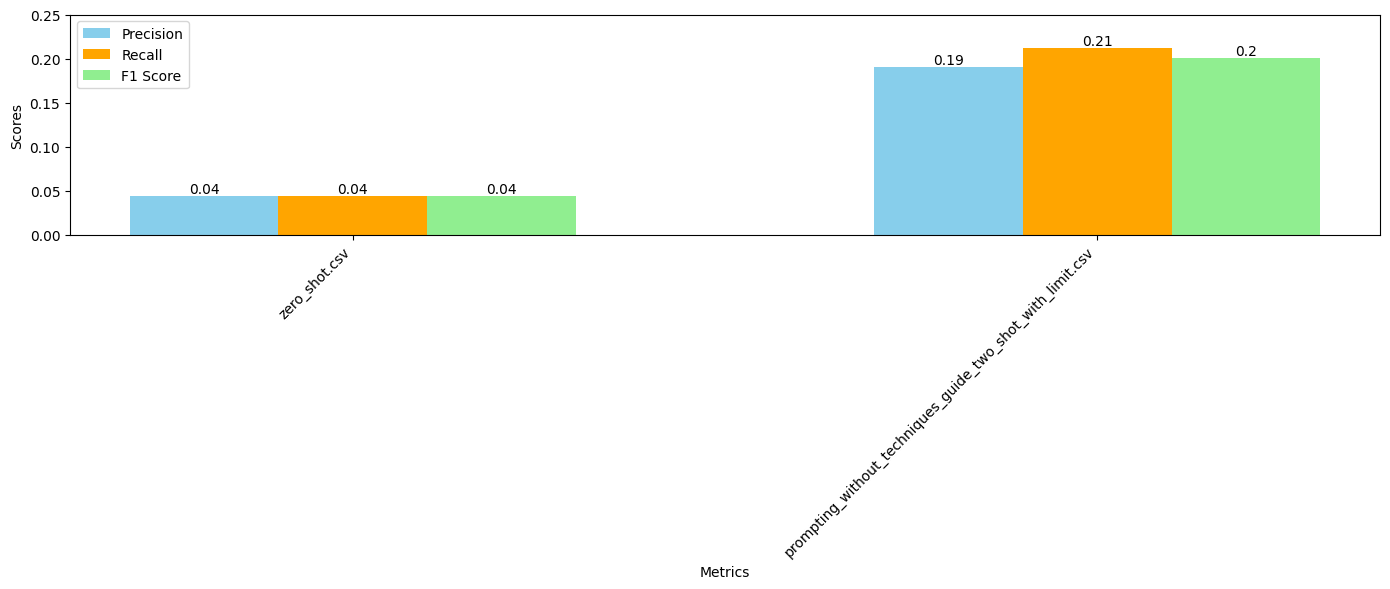

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists to accumulate evaluation results
all_precisions = []
all_recalls = []
all_f1_scores = []
xtick_labels = []  # Store xtick labels

# Loop over each file, load the data, and evaluate
for file in file_names:
    try:
        # Load the data
        loadData = pd.read_csv(file)

        # Extract the true and predicted labels
        true_labels = loadData['True_labels']
        predicted_labels = loadData['Technique_id']

        # Perform evaluation
        print(f'\nEvaluating {file}')
        results = evaluation(true_labels, predicted_labels, False)

        # Accumulate evaluation results
        for result in results:
            precision, recall, f1_score = result
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_f1_scores.append(f1_score)

        # Append filename for xtick labels
        file = file.split("/")[-1]
        xtick_labels.append(file)

    except KeyError as e:
        print(f'Error: Column {e} not found in {file}')
    except Exception as e:
        print(f'An error occurred while processing {file}: {e}')

# Plotting all evaluation results in a single plot
plt.figure(figsize=(14, 6))  # Adjust figure size as per requirement

bar_width = 0.2
index = range(len(all_precisions))

bars1 = plt.bar([i - bar_width for i in index], all_precisions, width=bar_width, color='skyblue', label='Precision')
bars2 = plt.bar(index, all_recalls, width=bar_width, color='orange', label='Recall')
bars3 = plt.bar([i + bar_width for i in index], all_f1_scores, width=bar_width, color='lightgreen', label='F1 Score')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(index, xtick_labels, rotation=45, ha='right')  # Rotate labels and adjust spacing

# Set custom y-axis limits
plt.ylim(0, 0.25)  # Adjust this line as per your requirement

plt.legend()

# Add score ranks on the bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Graph plot (all with [before and after limit 2 techniques and also competition or not])


---



~limit prompt | limit prompt


~competition | competition


~limit return | limit return



---

['prompting_with_techniques_guide_two_shot_False.csv', 'prompting_with_techniques_guide_zero_shot_False.csv', 'prompting_with_techniques_guide_one_shot_False.csv']
['Without_Prompt_Limit_Without_Competition_Without_Limit_Return', 'Without_Prompt_Limit_Without_Competition_With_Limit_Return', 'Response_Competition_1', 'Response_Competition_2', 'Response_Competition_3', 'Without_Prompt_Limit_With_Competition_Without_Limit_Return', 'Without_Prompt_Limit_With_Competition_With_Limit_Return']

Evaluating prompting_with_techniques_guide_zero_shot_False.csv

Evaluating prompting_with_techniques_guide_zero_shot_False.csv

Evaluating prompting_with_techniques_guide_zero_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_zero_shot_False.csv: argument of type 'int' is not iterable

Evaluating prompting_with_techniques_guide_zero_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_zero_shot_False.csv: argument of type 'int' is not iterable

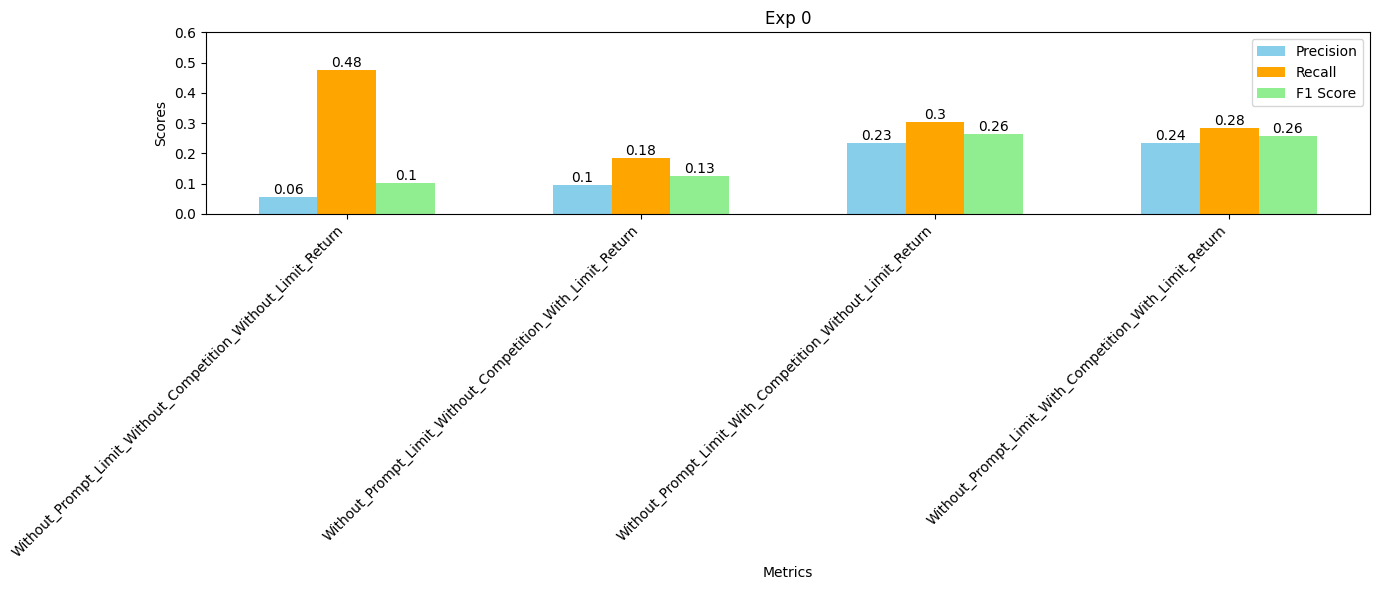

['Without_Prompt_Limit_Without_Competition_Without_Limit_Return', 'Without_Prompt_Limit_Without_Competition_With_Limit_Return', 'Response_Competition_1', 'Response_Competition_2', 'Response_Competition_3', 'Without_Prompt_Limit_With_Competition_Without_Limit_Return', 'Without_Prompt_Limit_With_Competition_With_Limit_Return']

Evaluating prompting_with_techniques_guide_one_shot_False.csv

Evaluating prompting_with_techniques_guide_one_shot_False.csv

Evaluating prompting_with_techniques_guide_one_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_one_shot_False.csv: argument of type 'int' is not iterable

Evaluating prompting_with_techniques_guide_one_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_one_shot_False.csv: argument of type 'int' is not iterable

Evaluating prompting_with_techniques_guide_one_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_one_shot_False.csv: argument of type 'i

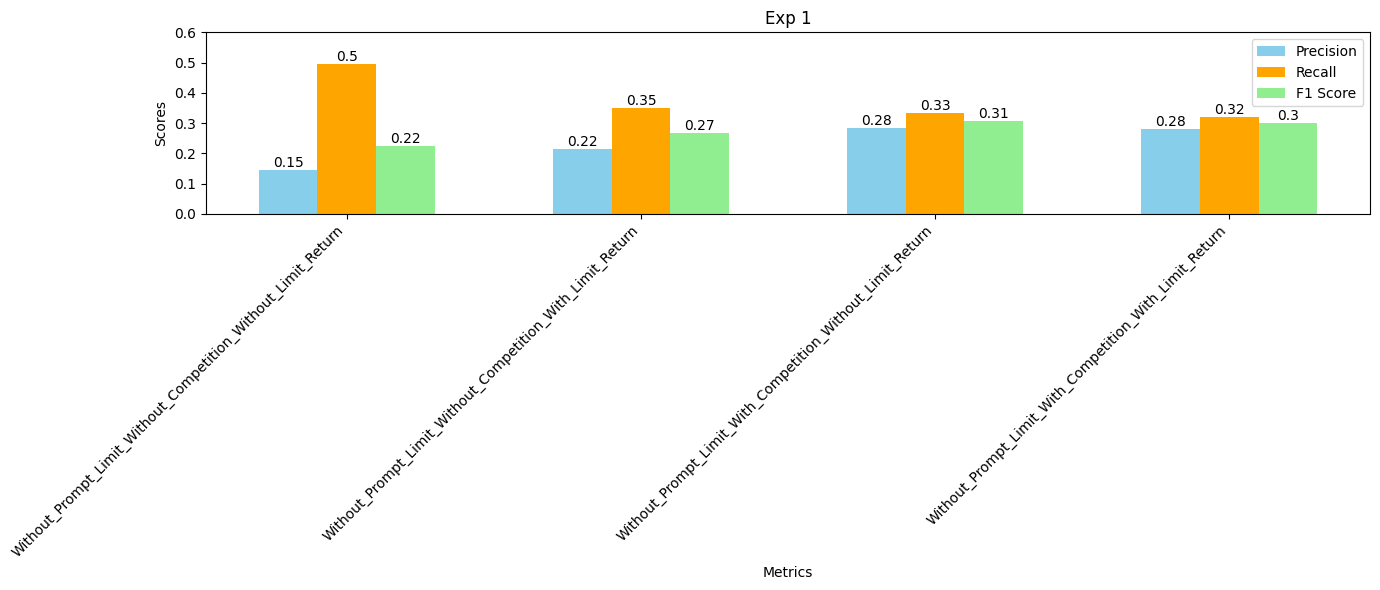

['Without_Prompt_Limit_Without_Competition_Without_Limit_Return', 'Without_Prompt_Limit_Without_Competition_With_Limit_Return', 'Response_Competition_1', 'Response_Competition_2', 'Response_Competition_3', 'Without_Prompt_Limit_With_Competition_Without_Limit_Return', 'Without_Prompt_Limit_With_Competition_With_Limit_Return']

Evaluating prompting_with_techniques_guide_two_shot_False.csv

Evaluating prompting_with_techniques_guide_two_shot_False.csv

Evaluating prompting_with_techniques_guide_two_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_two_shot_False.csv: argument of type 'int' is not iterable

Evaluating prompting_with_techniques_guide_two_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_two_shot_False.csv: argument of type 'int' is not iterable

Evaluating prompting_with_techniques_guide_two_shot_False.csv
An error occurred while processing prompting_with_techniques_guide_two_shot_False.csv: argument of type 'i

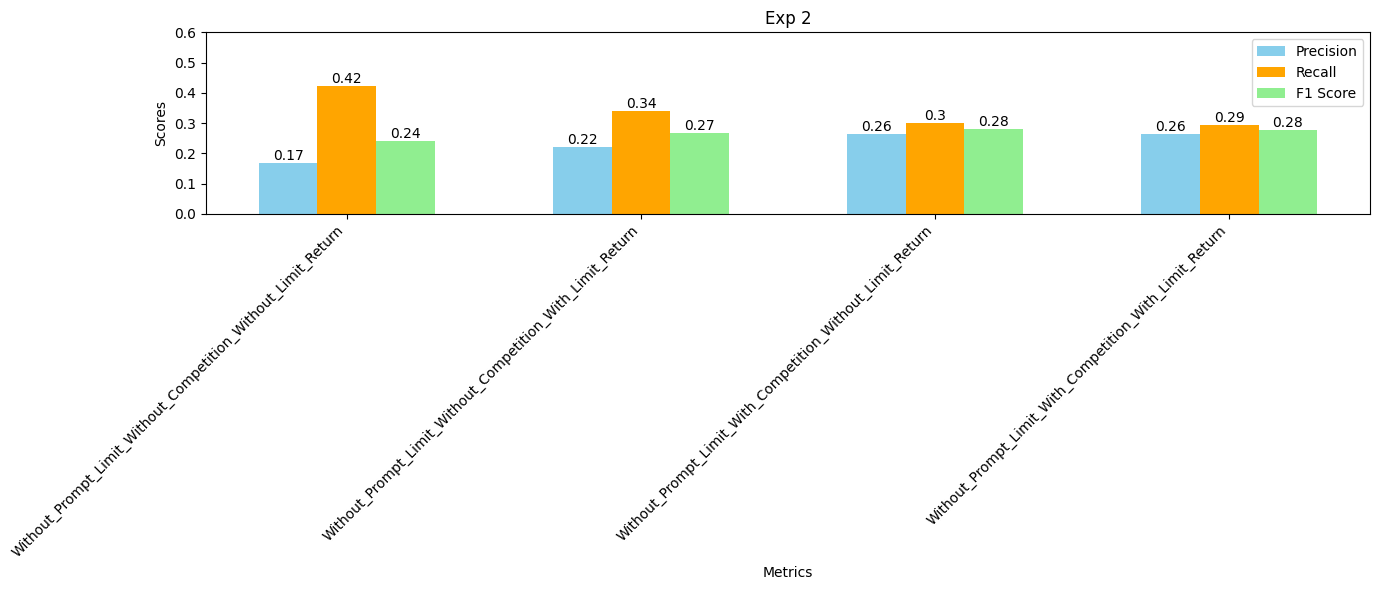

In [16]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

def get_column_names(csv_file_path):
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        column_names = next(reader)
    return column_names

def visualPlot(expNumber: list, plotName: int):
    # Initialize lists to accumulate evaluation results
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    xtick_labels = []  # Store xtick labels

    for file in expNumber:
        column_names = get_column_names(file)[2:-1]
        print(column_names)
        for cols in column_names:
            try:
                # Load the data
                loadData = pd.read_csv(file)

                # Extract the true and predicted labels
                true_labels = loadData['True_labels']
                predicted_labels = loadData[cols]

                # Perform evaluation using the existing evaluation function
                print(f'\nEvaluating {file}')
                results = evaluation(true_labels, predicted_labels, False)

                # Accumulate evaluation results
                for result in results:
                    precision, recall, f1_score = result
                    all_precisions.append(precision)
                    all_recalls.append(recall)
                    all_f1_scores.append(f1_score)

                # Append filename for xtick labels
                xtick_labels.append(cols)

            except KeyError as e:
                print(f'Error: Column {e} not found in {file}')
            except Exception as e:
                print(f'An error occurred while processing {file}: {e}')

    # # Create a new index order for the bars
    # new_order = [0, 4, 1, 5, 2, 6, 3, 7]  # Adjust this list according to your specific needs

    # # Reorder the evaluation results and xtick labels
    # all_precisions = [all_precisions[i] for i in new_order]
    # all_recalls = [all_recalls[i] for i in new_order]
    # all_f1_scores = [all_f1_scores[i] for i in new_order]
    # xtick_labels = [xtick_labels[i] for i in new_order]

    # Plotting all evaluation results in a single plot
    plt.figure(figsize=(14, 6))  # Adjust figure size as per requirement

    bar_width = 0.2
    index = range(len(all_precisions))

    bars1 = plt.bar([i - bar_width for i in index], all_precisions, width=bar_width, color='skyblue', label='Precision')
    bars2 = plt.bar(index, all_recalls, width=bar_width, color='orange', label='Recall')
    bars3 = plt.bar([i + bar_width for i in index], all_f1_scores, width=bar_width, color='lightgreen', label='F1 Score')

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f"Exp {plotName}")
    plt.xticks(index, xtick_labels, rotation=45, ha='right')  # Rotate labels and adjust spacing

    # Set custom y-axis limits
    plt.ylim(0, 0.6)  # Adjust this line as per your requirement

    plt.legend()

    # Add score ranks on the bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()




# List of file names
folder = r'/content/Labeling_IDS_to_MITRE/Semester_B/03 GPT/02 With batch'

file_dict = {0: [], 1: [], 2: []}

os.chdir(folder)  # Change path
items = os.listdir()  # List everything in the directory
print(items)


file_dict = {0: [], 1: [], 2: []}

# Define a function to determine the shot number
def get_shot_number(file_name):
    if "zero_shot" in file_name:
        return 0
    if "one_shot" in file_name:
        return 1
    if "two_shot" in file_name:
        return 2
    return -1  # default case if none of the above match

# Organize files into the dictionary based on shot number
for file_name in items:
    shot_number = get_shot_number(file_name)
    if shot_number != -1:
        file_dict[shot_number].append(file_name)

# Sort the lists within the dictionary to have False before True
for shot_number in file_dict:
    file_dict[shot_number].sort(key=lambda x: 'True' in x)


# Load all files into a dictionary of DataFrames
for k,v in file_dict.items():
  visualPlot(v, k) # [False, True]

